<a href="https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/TF_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The new version of TensorFlow is changing the way to code machine learning models to be more pythonic. Debugging and creating models were complicated with sessions and graphs but not anymore. Eager Execution allows evaluating tensors on the fly without having to run a session to execute code from end to end. Now, TensorFlow 2.0 introduces eager execution by default.  

#Install TF-2.0

TF 2.0 is not integrated with colab yet so you have to pip install it first 

In [0]:
!pip install tensorflow-gpu==2.0.0

# Import tensorflow

In [0]:
import tensorflow as tf

Check the version of tf

In [2]:
tf.__version__

'2.0.0'

# Executing Ops Eagerly 
By perfoming operations you can see the output directly without creating a session. 

In [3]:
x = [[2.]]
m = tf.square(x)
print(m)

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


You can call `.numpy` to retrieve the results of the tensor as a numpy array

In [5]:
m.numpy()

array([[4.]], dtype=float32)

You can also compute an operation including two tensors 

In [6]:
a = tf.constant([[1, 2],
                 [3, 4]])

b = tf.constant([[2, 1],
                 [3, 4]])

ab = tf.matmul(a, b)

print('a * b = \n', ab.numpy())

a * b = 
 [[ 8  9]
 [18 19]]


# Constants and Variables 


*   `tf.constant`, creates a constant tensor populated with the values as argument. The values are immutable. 
*   `tf.Variable `, this method encapsultes a mutable tensor that can be changed later using assign 


Creating a constant tensor 

In [7]:
a = tf.constant([[2,3]])
print(a)

tf.Tensor([[2 3]], shape=(1, 2), dtype=int32)


A constant tensor is immutable so you cannot assign a new value to it.

In [8]:
try:
  a.assign(2.)
except:
  print('Exception raised ')

Exception raised 


On the other hand variables are mutable and can be assigned a new value

In [9]:
v = tf.Variable(5.)

print('Old value for v =', v.numpy())
v.assign(2.)
print('New value for v =', v.numpy())

Old value for v = 5.0
New value for v = 2.0


You can also in-place increment/decrement the value of a tensor 

In [10]:
v.assign(2.)
print('value     : ', v.numpy())
print('increment : ', v.assign_add(1.).numpy())
print('decrement : ', v.assign_sub(1.).numpy())

value     :  2.0
increment :  3.0
decrement :  2.0


You can return many information from a tensor variable, like the name, type , shape and what device it executes on. 

In [11]:
print('name  : ', v.name)
print('type  : ', v.dtype)
print('shape : ', v.shape)
print('device: ', v.device)

name  :  Variable:0
type  :  <dtype: 'float32'>
shape :  ()
device:  /job:localhost/replica:0/task:0/device:GPU:0


# Gradient Evaluation

Gradient evaluation is very importnat machine learning because it is based on function optimization. You can use `tf.GradientTape()` method to record the gradient of an arbitrary function

In [12]:
w = tf.Variable(2.0)

#watch the gradient of the loss operation
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(f'The gradient of w^2 at {w.numpy()} is {grad.numpy()}')

The gradient of w^2 at 2.0 is 4.0


 In this example we evaluate the gradient of the sigmoid function 

$$\sigma(x) = \frac{1}{1+e^{-x}}$$

Note that 

$$\sigma'(x) = \frac{e^{-x}}{(1+e^{-x})^2} = \sigma(x)(1-\sigma(x)) $$

For isntance 

$$\sigma'(0) = \sigma(0)(1-\sigma(0)) = \frac{1}{2}\left(1-\frac{1}{2} \right) = \frac{1}{4}$$

In [0]:
def sigmoid(x):
  return 1/(1 + tf.exp(-x))

In [14]:
#define a varaible
x = tf.Variable(0.)

#record the gradient
with tf.GradientTape() as tape:
  y = sigmoid(x)
  
print('The gradient of the sigmoid function at 0.0 is ', tape.gradient(y, x).numpy())

The gradient of the sigmoid function at 0.0 is  0.25


You can also compute higher order derivatives by nesting a gradient functions. For instance, 

$$f(x) = \log(x) , f'(x) = \frac{1}{x}, f''(x) = \frac{-1}{x^2}$$

In [0]:
def log(x):
  return tf.math.log(x)

We could compute the gradient by nesting multiple gradient tapes 

In [16]:
#define a variable 
x = tf.Variable(1.)

#record second order gradient 
with tf.GradientTape() as t1:
  with tf.GradientTape() as t2:
    y = log(x)
  dx = t2.gradient(y, x)  
dx2 = t1.gradient(dx, x)

print('The first  derivative of log at x = 1 is ', dx.numpy())
print('The second derivative of log at x = 1 is ', dx2.numpy())

The first  derivative of log at x = 1 is  1.0
The second derivative of log at x = 1 is  -1.0


# Custom Gradients

Some times the gradient is not what we want espeically if there is a problem in numerical instabilitiy. Consider the following function and its gradient 

$$f(x) = \log(1+e^x)$$

The gradient is 

$$f'(x) = \frac{e^x}{1+e^x}$$

Note that at big values of $x$ the gradient value will blow up.

In [0]:
def logexp(x):
  return tf.math.log(1 + tf.exp(x))

In [0]:
def grad_logexp(x):
  with tf.GradientTape() as tape:
    y = logexp(x)
  dx = tape.gradient(y, x)
  return dx

In [19]:
x = tf.Variable(0.)
print('The gradient at x = 0  is ', grad_logexp(x).numpy())
x = tf.Variable(100.)
print('The gradient at x = 100 is ', grad_logexp(x).numpy()) 

The gradient at x = 0  is  0.5
The gradient at x = 100 is  nan


 We can revaluate the gradient by overriding the gradient of the function. We can recompute the gradient as 

$$f(x) =  \frac{1+e^x -e^x }{1+e^x} = 1 - \frac{1}{1 + e^{x}}$$

In [0]:
@tf.custom_gradient
def logexp_stable(x):
  e = tf.exp(x)
  #dy is optional, allows computation of vector jacobian products for vectors other than the vector of ones.
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

In [0]:
def grad_logexp(x):
  with tf.GradientTape() as tape:
    y = logexp_stable(x)
  dx = tape.gradient(y, x)
  return dx

In [22]:
x = tf.Variable(100.)
print('The gradient at x = 100 is ', grad_logexp(x).numpy()) 

The gradient at x = 100 is  1.0


# tf.function

tf.function is a very useful module that can be used to convert simple python functions to static graph operators. For instance, it is difficult to use conditions in graphs but we could implement that easily using `@tf.function` decorator. 

We know that $f(x) = |x|$ has no derivative at $0$ so we can estimate the derivative at $)$ as $0$ using the following function
$$g(x) = 
\begin{cases}
1 & x > 0 \\
-1 & x < 0 \\
0 & x = 0 
\end{cases}$$

In [0]:
@tf.function 
def g(x):
  if x > 0:
    return 1
  elif x < 0:
    return -1
  else:
    return 0

In [38]:
print('If value is positive ', g(3).numpy())
print('If value is negative ', g(-3).numpy())
print('If value is zero ', g(0).numpy())

If value is positive  1
If value is negative  -1
If value is zero  0


# Object Oriented Metrics
You can use `metrics` to record tensors/values and operate on them at the end. This is useful when recording the training history and you want to evaluate it at the end. Use `.result()` to evaluate the metric at the end. 

In [39]:
m = tf.keras.metrics.Mean("loss")

#record the loss 
m(2)
m(4)

print('The mean loss is ', m.result().numpy())

The mean loss is  3.0


If you want to remove the recorded values, you can `reset` the variables 

In [40]:
m.reset_states()
print('The mean loss is ', m.result().numpy())

The mean loss is  0.0


# Linear Regression 

This example is refactored from https://www.tensorflow.org/guide/eager. We create a complete example of using linear regression to predict the paramters of the function 

$$f(x) = 3 x + 2 + noise$$

Given a point $x$ we want to predict the value of $y$. We train the model on 1000 data pairs $(x,f(x))$. 

The model to learn is a linear model 

$$\hat{y} = W x + b$$

Note that, we use `tf.GradientTape` to record the gradient with respect our trainable paramters.  

We MSE to calcuate the loss 

$$g = (y-\hat{y})^2$$

We use Gradient Descent to update the paramters 

$$W = W - \alpha  \frac{\partial g}{\partial W}$$

$$b = b - \alpha  \frac{\partial g}{\partial b}$$

In [41]:
#1000 data points 
NUM_EXAMPLES = 1000

#define inputs and outputs with some noise 
X = tf.random.normal([NUM_EXAMPLES])  #inputs 
noise = tf.random.normal([NUM_EXAMPLES]) #noise 
y = X * 3 + 2 + noise  #true output

#create model paramters with initial values 
W = tf.Variable(0.)
b = tf.Variable(0.)

#training info
train_steps = 200
learning_rate = 0.01

for i in range(train_steps):
  
  #watch the gradient flow 
  with tf.GradientTape() as tape:
    
    #forward pass 
    yhat = X * W + b
    
    #calcuate the loss (difference squared error)
    error = yhat - y
    loss = tf.reduce_mean(tf.square(error))
  
  #evalute the gradient with the respect to the paramters
  dW, db = tape.gradient(loss, [W, b])

  #update the paramters using Gradient Descent  
  W.assign_sub(dW * learning_rate)
  b.assign_sub(db* learning_rate)

  #print the loss every 20 iterations 
  if i % 20 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss))
      
print(f'W : {W.numpy()} , b  = {b.numpy()} ')

Loss at step 000: 14.922
Loss at step 020: 6.879
Loss at step 040: 3.467
Loss at step 060: 2.020
Loss at step 080: 1.406
Loss at step 100: 1.145
Loss at step 120: 1.035
Loss at step 140: 0.988
Loss at step 160: 0.968
Loss at step 180: 0.959
W : 2.9483070373535156 , b  = 2.03007173538208 


# Dataset Processing and Augmentation

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

You can easily use MNIST 

In [43]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


We can apply a set of transformations using `tf.image`

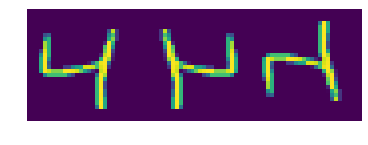

In [44]:
img = x_train[2:3]
img = np.expand_dims(img, -1)

#flipping horizontally
img1 = tf.image.flip_left_right(img)

#flipping vertically
img2 = tf.image.flip_up_down(img)


plt.axis('off')
plt.imshow(tf.concat([img, img1, img2], axis = 2).numpy().squeeze())
plt.show()

Here we examplain the pipeline of creating a dataset. Note that we have 3 main important functions in `tf.data.Dataset `



*   `from_tensor_slices` which convert the input to a tensor 
*   `map` which applies a certain function to every tensor 
* `batch` which creates a batch of tensors of certain size



In [0]:
def pre_process(x, y):
  #normalize and expand
  x = tf.cast(x, tf.float32)/255.
  x = tf.expand_dims(x, -1)
  
  #cast the labels
  y = tf.cast(y, tf.int32)
  return x, y

def create_dataset(x, y):  
  #convert to tensors and shuffle
  dataset = tf.data.Dataset.from_tensor_slices((x , y)).shuffle(len(x)-1)
  
  #extract batches
  dataset = dataset.batch(32)
  
  #preprocess the batch
  dataset = dataset.map(pre_process, num_parallel_calls = 4)
  
  return dataset

Now we can create a dataset and iterate over it 

In [0]:
train_dataset = create_dataset(x_train, y_train)
test_dataset  = create_dataset(x_test , y_test)

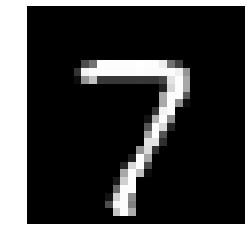

In [48]:
for x, y in train_dataset:
  plt.imshow(x[0].numpy().squeeze(), cmap = 'gray')
  plt.axis('off')
  plt.show()
  break

# Custom Layers

In this section we learn how to make custom layers. But, first let us learn how to create **initializers**. Initializers are used to create the initiall parameters of a given layer. Let us create a uniform random initialzers. 

In [0]:
initializer = tf.random_uniform_initializer()

Then we can create a tensor initialized with values extracted from a uniform distribution

In [50]:
x = tf.Variable(initializer(shape = (10,)))
print(x.numpy())

[-0.02233864  0.017819    0.0269908   0.03113348  0.00084861 -0.00289609
 -0.00307513  0.00185374 -0.01953651 -0.0307086 ]


Now, let us create a simple linear layer. A linear layer is defined in the following fashion 

$$y = WX+b$$

where $X$ is the input batch, $W$ is the weight matrix and $b$ is the bias. 

In [0]:
from tensorflow.keras.layers import Layer

In [0]:
class Linear(Layer):

  def __init__(self, units=32, input_dim=32):
      super(Linear, self).__init__()
      
      #random initializer for the weights 
      w_init = tf.random_normal_initializer()
      self.w = tf.Variable(
          initial_value=w_init(shape=(input_dim, units), dtype='float32'),
          trainable=True)
      
      #zero initialized biases
      b_init = tf.zeros_initializer()
      self.b = tf.Variable(
          initial_value=b_init(shape=(units,), dtype='float32'),
          trainable=True)

  def call(self, inputs):
      #froward call
      return tf.matmul(inputs, self.w) + self.b

In [0]:
#create a simple linear layer that has 10 neorons and accept inputs of size 3
llayer = Linear(units = 10, input_dim = 3)

In [54]:
#forward call of batch of size 3
llayer(tf.ones((3, 3)))

<tf.Tensor: id=7922, shape=(3, 10), dtype=float32, numpy=
array([[-0.07493173, -0.07062794,  0.14689818,  0.03446626, -0.11261825,
        -0.0377239 ,  0.05364574,  0.05783478,  0.0324616 , -0.14853328],
       [-0.07493173, -0.07062794,  0.14689818,  0.03446626, -0.11261825,
        -0.0377239 ,  0.05364574,  0.05783478,  0.0324616 , -0.14853328],
       [-0.07493173, -0.07062794,  0.14689818,  0.03446626, -0.11261825,
        -0.0377239 ,  0.05364574,  0.05783478,  0.0324616 , -0.14853328]],
      dtype=float32)>

# End-to-End CNN Example

Here we create a simple convolutional neural network (CNN)to recognize hand-written digits (MNIST). We start by creating a simple alexnet CNN model. 

![alt text](https://i.imgur.com/twUKrlo.png)

In [0]:
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

In [0]:
def create_model():
  model = Sequential()
  model.add(Convolution2D(filters = 16, kernel_size = 3, padding = 'same', input_shape = [28, 28, 1], activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Convolution2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Flatten())
  model.add(Dense(units = 100, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 10 , activation = 'softmax'))
  return model

## Create the model 

In [57]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               156900    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

Look at the output by frowarding a batch of zero images. 

In [58]:
import numpy as np
model(np.zeros((10, 28, 28, 1), np.float32))

<tf.Tensor: id=8109, shape=(10, 10), dtype=float32, numpy=
array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32)>

## Design the loss function, Gradient and Accuracy metric

In [0]:
#evaluate the loss
def loss(y, yhat):
  #this applies the loss to sparse labels i.e not one hot encoded 
  return tf.keras.losses.sparse_categorical_crossentropy(y, yhat)

#record the gradient with respect to the model variables 
def grad(model, x, y):
  with tf.GradientTape() as tape:
    yhat = model(x)
    loss_value = loss(y, yhat)
  return tape.gradient(loss_value, model.trainable_variables)

#calcuate the accuracy of the model 
def accuracy(y, yhat):
  
  #get the labels of the predicted values 
  yhat = tf.argmax(yhat, 1).numpy()
  
  #get the labels of the true values
  y    = y.numpy()
  return np.sum(y == yhat)/len(y)

## Intitalize the variables

In [0]:
#use Adam optimizer 
optimizer = tf.keras.optimizers.Adam()

#record epoch loss and accuracy  
loss_history = tf.keras.metrics.Mean("loss")
accuracy_history = tf.keras.metrics.Mean("accuracy")

#epochs
epochs = 3

## Training

In [61]:
for epoch in range(1, epochs + 1):
  for x, y in train_dataset:
    
    yhat = model(x)
    # Calculate derivatives of the input function with respect to its parameters.
    grads = grad(model, x, y)

    # Apply the gradient to the model
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    #record the current loss and accuracy   
    loss_history(loss(y, yhat))
    accuracy_history(accuracy(y, yhat))

  print("epoch: {:d} Loss: {:.3f}, Acc: {:.3f}".format(epoch, loss_history.result(), accuracy_history.result()))

  #clear the history 
  loss_history.reset_states()
  accuracy_history.reset_states()

epoch: 1 Loss: 0.147, Acc: 0.955
epoch: 2 Loss: 0.045, Acc: 0.986
epoch: 3 Loss: 0.031, Acc: 0.990


## Testing

In [62]:
accuracy_history.reset_states()
for x, y in test_dataset:
    # Calculate derivatives of the input function with respect to its parameters.
    yhat = model(x)

    #record the current loss and accuracy   
    accuracy_history(accuracy(y, yhat))
print("Acc: {:.2f}".format(accuracy_history.result()))

Acc: 0.99


# Save and Restore a Model
You can save training history then restore it later. 

In [0]:
#create a directory for saving the model
import os

#check if it exists
if os.path.isdir('model'):
  raise Exception('Folder exists !')
else:
  checkpoint_dir = 'model'
  os.mkdir(checkpoint_dir)

  #create a root for the checkpoint
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  root = tf.train.Checkpoint(optimizer=optimizer,
                             model=model)

  #save the model 
  root.save(file_prefix=checkpoint_prefix)

Restore the model 

In [0]:
#create an empty model 
model = create_model()

#create a checkpoint variable 
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=create_model())

#restore the model
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

#retrieve the trained model 
model = root.model 

## References 



1.   https://www.tensorflow.org/tutorials

